# Organisms Classifier

+ In this notebook we could observe the use of the EfficientNet,ResNet Class, Data Augmentation and Weight & Bias tracker. Also the sweep function is available in order to tune the hyperparameters od the model (using Grid, Random or Bayes)

In [13]:
import os
import sys
module_path = "../src"
#os.environ["WANDB_SILENT"] = "true" # Environment Variable to make wandb silent
if module_path not in sys.path:
    sys.path.append(module_path)

In [14]:
# 1. General Libraries
import pandas as pd
import numpy as np
from pathlib import Path
import yaml
# 2. DataModule & Class Libraries
from utils.label_encoder import label_encoder_target
from utils.calc_stat import calc_dataset_mean_std
from dataset.ImageDataModule import ImageDataModule
from dataset.ImageDataset import ImageDataset
from models.EfficientNetClass import EfficientNetClass
from models.ResNetClass import ResNetClass

# 3. Pytorch & Pytorch Lightning Libraries
from pytorch_lightning import Trainer,seed_everything
from torchvision import transforms
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
import torch
# 4. Wandb Tracker Experiements
import wandb

### 2. General Variables
 Here we stablish some general variables that will be used in all the experiements.In this case we will have less general variables because we will tune some of them using the sweep api.For example:
 + SEED           : Seed in order to ensure reproducibility
 + PROJECT        : Name of the project
 + NUM_WORKERS    : Number of workers in the cluster
 + METRIC_MONITOR : Metric that will be monitor in the sweep api

In [15]:
BASE_PATH = Path('/mnt')
print(f"My base path is {BASE_PATH}")
DATA_PATH = '../data/organism_modality.csv'
print(f"The given dataset is located here: {DATA_PATH}")
OUTPUT_DIR = Path('/mnt/artifacts/experiments/')
print(f"Let's use this folder: {OUTPUT_DIR} to save our artifacts.")
BASE_IMG_DIR = BASE_PATH / 'subfigure-classification'       # the image path in the CSV file are relative to this directory

My base path is /mnt
The given dataset is located here: ../data/organism_modality.csv
Let's use this folder: /mnt/artifacts/experiments to save our artifacts.


In [16]:
SEED = 42 
seed_everything(42)
PROJECT = 'Biomedical-Image-Classification-Organisms'
NUM_WORKERS = 72 # workers on the cluster, normally 2 or 4 on a laptop
METRIC_MONITOR = "val_avg_loss"
OUTPUT_PROJECT = OUTPUT_DIR/PROJECT
print(f"Let's use this folder {OUTPUT_PROJECT} to save our sweep iterations")
os.makedirs(OUTPUT_PROJECT, exist_ok=True) # Check if it is false

Let's use this folder /mnt/artifacts/experiments/Biomedical-Image-Classification-Organisms to save our sweep iterations


### 3. Reading the Data & Label Encoding Classes
In this step, we read the csv file and apply a label encoder to the classes in order to run the classifier

In [17]:
df = pd.read_csv(DATA_PATH, sep='\t')
le_encoder_organisms,dict_label = label_encoder_target(df,target_col = 'modality')
df.head()

,img,modality,set,source,img_path,higher_modality,caption,split_set
0,12178_2008_9027_Fig4_HTML-1.jpg,x-rays,TRAIN,clef16,2016/train/DRXR/12178_2008_9027_Fig4_HTML-1.jpg,ORGANISMS,( a ) This anteroposterior radiograph demonstr...,TRAIN
1,12178_2008_9027_Fig4_HTML-2.jpg,x-rays,TRAIN,clef16,2016/train/DRXR/12178_2008_9027_Fig4_HTML-2.jpg,ORGANISMS,( a ) This anteroposterior radiograph demonstr...,VAL
2,12178_2008_9027_Fig4_HTML-3.jpg,x-rays,TRAIN,clef16,2016/train/DRXR/12178_2008_9027_Fig4_HTML-3.jpg,ORGANISMS,( a ) This anteroposterior radiograph demonstr...,TRAIN
3,12178_2009_9056_Fig9_HTML-1.jpg,other,TRAIN,clef16,2016/train/DRUS/12178_2009_9056_Fig9_HTML-1.jpg,ORGANISMS,CTS patient #4. Longitudinal view of the media...,VAL
4,12178_2009_9056_Fig9_HTML-2.jpg,other,TRAIN,clef16,2016/train/DRUS/12178_2009_9056_Fig9_HTML-2.jpg,ORGANISMS,CTS patient #4. Longitudinal view of the media...,TRAIN


In [18]:
dict_label

{'mri/ct': 0, 'other': 1, 'photos': 2, 'x-rays': 3}

In [19]:
transform_list = [
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
]
transform  = transforms.Compose(transform_list)
train_dataset   = ImageDataset   (DATA_PATH,
                                  le_encoder_organisms,
                                  str(BASE_IMG_DIR),
                                  'TRAIN',
                                  image_transform=transform,
                                  label_name='modality',
                                  target_class_col='split_set',
                                  path_col='img_path')
mean, std =calc_dataset_mean_std(train_dataset, batch_size=32, num_workers=32)
print(f"Mean:  {mean}")
print(f"Std :  {std}")


Mean:  tensor([0.3699, 0.3653, 0.3616])
Std :  tensor([0.2935, 0.2881, 0.2884])


## 4. Sweep Runing

In [20]:
# Image Transformations
# 1.1 Train Transformations
train_transform = [
                    transforms.ToPILImage(),
                    transforms.Resize((256, 256)),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomRotation(15),
                    transforms.CenterCrop((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean.numpy(), std.numpy())
                ]
train_transform  = transforms.Compose(train_transform )

# 1.2 Valid Transformations
val_transform = [
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean.numpy(),std.numpy())
                ]
val_transform = transforms.Compose(val_transform)

# 1.3 Test Transformations
test_transform = [
                  transforms.ToPILImage(),
                  transforms.Resize((224, 224)),
                  transforms.ToTensor(),
                  transforms.Normalize(mean.numpy(),std.numpy())
                  ]
test_transform = transforms.Compose(test_transform)

In [21]:
print(f"PROJECT NAME: {PROJECT}")
print(f"Metric Monitor: {METRIC_MONITOR}")

PROJECT NAME: Biomedical-Image-Classification-Organisms
Metric Monitor: val_avg_loss


### 4.1 ResnetClassfifier

In [22]:
sweep_config = {
  "method": "grid",   # Random search
  "metric": {           # We want to maximize val_acc
      "name": METRIC_MONITOR, # Used accuracy
      "goal": "minimize"
  },
  "parameters": {
        "lr": {
            # log uniform distribution between exp(min) and exp(max)
            "distribution": "categorical",
            "values" : [0.00001]
        },
        "fine_tuned_from":{
            "distribution": "categorical",
            "values" : ["whole"]
        },
        "name":{
            "distribution": "categorical",
            "values" : ["resnet152"]
        },
        "batch_size":{
            "distribution": "categorical",
            "values" : [32]
            
        }
      
    }
}

In [23]:
sweep_id = wandb.sweep(sweep_config, project=PROJECT)

Create sweep with ID: 914b1mhy
Sweep URL: https://wandb.ai/williamberrios/Biomedical-Image-Classification-Organisms/sweeps/914b1mhy


In [24]:
OUTPUT_SWEEP = OUTPUT_PROJECT / sweep_id
os.makedirs(OUTPUT_SWEEP, exist_ok=False) # Check if it is false
with open(OUTPUT_SWEEP / 'sweep_config.yml', 'w') as outfile:
    yaml.dump(sweep_config, outfile, default_flow_style=False)

In [26]:
def sweep_iteration():
    # set up W&B logger
    wandb.init()    # required to have access to `wandb.config`
    wandb_logger =  WandbLogger(project=PROJECT, tags=['nb', 'higher-modality'],reinit = True)
    wandb_logger.experiment.save()
    print(f"Name of the Experiment: {wandb_logger.experiment.name}")
    output_run_path = OUTPUT_SWEEP / wandb_logger.experiment.name 
    os.makedirs(output_run_path, exist_ok=False) # Check if it is false

    # setup data
    dm = ImageDataModule( batch_size       = wandb.config.batch_size,
                          label_encoder    = le_encoder_organisms,
                          data_path        = str(DATA_PATH), 
                          base_img_dir     = str(BASE_IMG_DIR),
                          seed             = SEED,   
                          image_transforms = [train_transform,val_transform,test_transform],
                          num_workers      = 72,
                          target_class_col ='split_set',
                          modality_col     ='modality',
                          path_col         ='img_path')
    dm.prepare_data()
    dm.setup()
    dm.set_seed()
    # Callbacks
    lr_monitor = LearningRateMonitor(logging_interval='epoch')

    early_stop_callback = EarlyStopping(
        monitor=METRIC_MONITOR,
        min_delta=0.0,
        patience=5,
        verbose=True,
        mode='min'
    )
    # setup model - note how we refer to sweep parameters with wandb.config
    num_classes = len(df.modality.unique())
    print(f"Num_Classes {num_classes}")
    model = ResNetClass(      name            = wandb.config.name,
                              num_classes     = num_classes,
                              pretrained      = True,
                              fine_tuned_from = wandb.config.fine_tuned_from,
                              lr              = wandb.config.lr,
                              metric_monitor  = METRIC_MONITOR,
                              mode_scheduler  = "min",
                              class_weights   = dm.class_weights,
                              mean_dataset    = mean.numpy(),
                              std_dataset     = std.numpy())
    
    # setup Trainer
    trainer = Trainer(gpus=1,
                  max_epochs=100,                  
                  callbacks=[early_stop_callback,lr_monitor],
                  deterministic= True,
                  logger=wandb_logger,
                  num_sanity_val_steps=0)

    # train
    trainer.fit(model, dm)
    # Save the model
    trainer.save_checkpoint(str(output_run_path / 'final.pt'))
    # Get testS metric
    trainer.test(model, test_dataloaders=dm.val_dataloader())
    del model,trainer,dm
    torch.cuda.empty_cache() 
    wandb.finish()


wandb: Agent Starting Run: x7i6oqtu with config:
wandb: 	batch_size: 32
wandb: 	fine_tuned_from: whole
wandb: 	lr: 1e-05
wandb: 	name: resnet152
wandb: Currently logged in as: williamberrios (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.20 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Name of the Experiment: copper-sweep-1
Num_Classes 4


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 58.2 M
-----------------------------------------------
58.2 M    Trainable params
0         Non-trainable params
58.2 M    Total params


Epoch     9: reducing learning rate of group 0 to 1.0000e-06.


wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).


Accuracy: 94.60784149169922
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94       155
         1.0       0.94      0.94      0.94       216
         2.0       0.98      1.00      0.99        50
         3.0       0.97      0.92      0.94       191

    accuracy                           0.95       612
   macro avg       0.95      0.96      0.95       612
weighted avg       0.95      0.95      0.95       612


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.9572556797212683,
 'Macro F1-Score': 0.9542524457585961,
 'test_acc': tensor(94.6078, device='cuda:0'),
 'test_loss': tensor(0.1916, device='cuda:0')}
--------------------------------------------------------------------------------


lr-Adam,0.0
_step,1539
_runtime,474
_timestamp,1614103200
val_acc,94.60784
val_avg_loss,0.19164
epoch,9
train_acc,98.81342
train_avg_loss,0.03885
test_acc,94.60784
test_loss,0.19164


lr-Adam,█████████▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄█
_runtime,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
_timestamp,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
val_acc,▁▅▆▇██▆▇▇▇
val_avg_loss,█▃▂▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇██
train_acc,▁▆▇▇▇█████
train_avg_loss,█▄▃▂▂▁▁▁▁▁
test_acc,▁
test_loss,▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


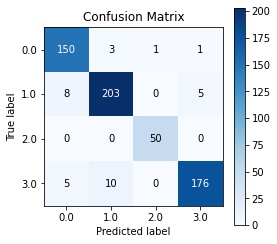

In [27]:
wandb.agent(sweep_id, function=sweep_iteration);

### 4.2 EfficientNetClassifier

In [28]:
sweep_config = {
  "method": "grid",   # Random search
  "metric": {           # We want to maximize val_acc
      "name": METRIC_MONITOR, # Used accuracy
      "goal": "minimize"
  },
  "parameters": {
        "lr": {
            # log uniform distribution between exp(min) and exp(max)
            "distribution": "categorical",
            "values" : [1e-4]
        },
        "fine_tuned_from":{
            "distribution": "categorical",
            "values" : ["whole"]
        },
        "name":{
            "distribution": "categorical",
            "values" : ["efficientnet-b0"]
        },
        "batch_size":{
            "distribution": "categorical",
            "values" : [32]
            
        }
      
    }
}

In [29]:
sweep_id = wandb.sweep(sweep_config, project=PROJECT)

Create sweep with ID: slmz1how
Sweep URL: https://wandb.ai/williamberrios/Biomedical-Image-Classification-Organisms/sweeps/slmz1how


In [30]:
OUTPUT_SWEEP = OUTPUT_PROJECT / sweep_id
os.makedirs(OUTPUT_SWEEP, exist_ok=False) # Check if it is false
with open(OUTPUT_SWEEP / 'sweep_config.yml', 'w') as outfile:
    yaml.dump(sweep_config, outfile, default_flow_style=False)

In [31]:
def sweep_iteration():
    # set up W&B logger
    wandb.init()    # required to have access to `wandb.config`
    wandb_logger =  WandbLogger(project=PROJECT, tags=['nb', 'higher-modality'],reinit = True)
    wandb_logger.experiment.save()
    print(f"Name of the Experiment: {wandb_logger.experiment.name}")
    output_run_path = OUTPUT_SWEEP / wandb_logger.experiment.name 
    os.makedirs(output_run_path, exist_ok=False) # Check if it is false

    # setup data
    dm = ImageDataModule( batch_size       = wandb.config.batch_size,
                          label_encoder    = le_encoder_organisms,
                          data_path        = str(DATA_PATH), 
                          base_img_dir     = str(BASE_IMG_DIR),
                          seed             = SEED,   
                          image_transforms = [train_transform,val_transform,test_transform],
                          num_workers      = 72,
                          target_class_col ='split_set',
                          modality_col     ='modality',
                          path_col         ='img_path')
    dm.prepare_data()
    dm.setup()
    dm.set_seed()
    # Callbacks
    lr_monitor = LearningRateMonitor(logging_interval='epoch')

    early_stop_callback = EarlyStopping(
        monitor=METRIC_MONITOR,
        min_delta=0.0,
        patience=5,
        verbose=True,
        mode='min'
    )
    # setup model - note how we refer to sweep parameters with wandb.config
    num_classes = len(df.modality.unique())
    print(f"Num_Classes {num_classes}")
    model = EfficientNetClass(name            = wandb.config.name,
                              num_classes     = num_classes,
                              pretrained      = True,
                              fine_tuned_from = wandb.config.fine_tuned_from,
                              lr              = wandb.config.lr,
                              metric_monitor  = METRIC_MONITOR,
                              mode_scheduler  = "min",
                              class_weights   = dm.class_weights,
                              mean_dataset    = mean.numpy(),
                              std_dataset     = std.numpy())
    
    # setup Trainer
    trainer = Trainer(gpus=1,
                  max_epochs=100,                  
                  callbacks=[early_stop_callback,lr_monitor],
                  deterministic= True,
                  logger=wandb_logger,
                  num_sanity_val_steps=0)

    # train
    trainer.fit(model, dm)
    # Save the model
    trainer.save_checkpoint(str(output_run_path / 'final.pt'))
    # Get testS metric
    trainer.test(model, test_dataloaders=dm.val_dataloader())
    del model,trainer,dm
    torch.cuda.empty_cache() 
    wandb.finish()

wandb: Agent Starting Run: hwy3gghz with config:
wandb: 	batch_size: 32
wandb: 	fine_tuned_from: whole
wandb: 	lr: 0.0001
wandb: 	name: efficientnet-b0
wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


Name of the Experiment: lucky-sweep-1
Num_Classes 4


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | EfficientNet     | 4.0 M 
-----------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params


Loaded pretrained weights for efficientnet-b0


Epoch     8: reducing learning rate of group 0 to 1.0000e-05.


wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).


Accuracy: 92.81045532226562
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.93       155
         1.0       0.94      0.88      0.90       216
         2.0       0.98      1.00      0.99        50
         3.0       0.94      0.94      0.94       191

    accuracy                           0.93       612
   macro avg       0.94      0.94      0.94       612
weighted avg       0.93      0.93      0.93       612


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.944674674885999,
 'Macro F1-Score': 0.9399547122962131,
 'test_acc': tensor(92.8105, device='cuda:0'),
 'test_loss': tensor(0.2205, device='cuda:0')}
--------------------------------------------------------------------------------


lr-Adam,1e-05
_step,1385
_runtime,188
_timestamp,1612972563
val_acc,92.81046
val_avg_loss,0.22049
epoch,8
train_acc,98.19968
train_avg_loss,0.05654
test_acc,92.81046
test_loss,0.22049


lr-Adam,████████▁
_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄█
_runtime,▁▁▂▂▃▃▄▄▄▄▅▅▆▆▇▇███
_timestamp,▁▁▂▂▃▃▄▄▄▄▅▅▆▆▇▇███
val_acc,▁▅▇██████
val_avg_loss,█▄▃▁▁▁▁▁▁
epoch,▁▂▃▄▅▅▆▇██
train_acc,▁▆▇▆▇████
train_avg_loss,█▃▂▂▂▁▁▁▁
test_acc,▁
test_loss,▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


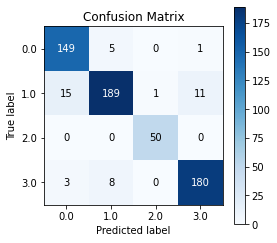

In [32]:
wandb.agent(sweep_id, function=sweep_iteration);

## 5. Testing

In [41]:
cp /mnt/artifacts/experiments/Biomedical-Image-Classification-Organisms/914b1mhy/copper-sweep-1/final.pt /mnt/artifacts/models/Organisms/

In [35]:
model_path = '/mnt/artifacts/experiments/Biomedical-Image-Classification-Organisms/914b1mhy/copper-sweep-1/final.pt'
# setup data
dm = ImageDataModule( batch_size           = 32,
                          label_encoder    = le_encoder_organisms,
                          data_path        = str(DATA_PATH), 
                          base_img_dir     = str(BASE_IMG_DIR),
                          seed             = SEED,   
                          image_transforms = [train_transform,val_transform,test_transform],
                          num_workers      = 72,
                          target_class_col ='split_set',
                          modality_col     ='modality',
                          path_col         ='img_path')
dm.prepare_data()
dm.setup()
dm.set_seed()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Accuracy: 90.22403717041016
              precision    recall  f1-score   support

         0.0       0.77      0.96      0.86        71
         1.0       0.99      0.90      0.94       364
         2.0       0.86      0.95      0.90        38
         3.0       0.40      0.67      0.50        18

    accuracy                           0.90       491
   macro avg       0.75      0.87      0.80       491
weighted avg       0.93      0.90      0.91       491


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.8675333037360464,
 'Macro F1-Score': 0.7990882765485725,
 'test_acc': tensor(90.2240, device='cuda:0'),
 'test_loss': tensor(0.2579, device='cuda:0')}
--------------------------------------------------------------------------------


[{'test_acc': 90.22403717041016,
  'test_loss': 0.25789839029312134,
  'Macro F1-Score': 0.7990882765485725,
  'Balanced Accuracy': 0.8675333037360464}]

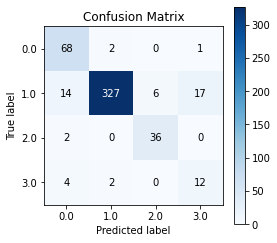

In [36]:
model = ResNetClass.load_from_checkpoint(model_path)
trainer = Trainer(gpus=1, logger=None)
trainer.test(model, test_dataloaders=dm.test_dataloader())